In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
from numpy import mean
from numpy import std
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy.stats import norm
from scipy import stats
from scipy.stats import uniform, truncnorm, randint
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/churn-modelling/Churn_Modelling.csv


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, recall_score, precision_score, f1_score, accuracy_score, precision_recall_curve, roc_auc_score, classification_report, confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Introduction

In the 1st iteration I've used the following pipeline:
* Standard Scaler
* Oversampling
* Random Forest Classifier

And reached the following score:
* Final Test ROC-AUC: 0.79 \
Which is not good, since approximately 79% of the dataset have exited.

The most important features according to the classifier were Age (which was transformed with Box-Cox, although this shouldn't matter in RF) and NumOfProducts, which I think it is a distorsive feature with cuestionable information. The least important features are HasCrCard, Geography and Gender. I had also created 2 features which are ratios of Age: one whith Credit Score (which was pretty important in the model) and other with Estimated Salary (which was less important).

In this notebook I will use the results from the 1st iteration to see if I can improve the final score. For this, I will be focusing mainly on **Feature Engineering techniques**. The pipeline will stay the same, meaning I will use Standard Scaler to scale the data, Oversampling as the resampler and Random Forests as the model. Comparing the different techniques using the same pipeline I can compare them and see which one yields the best results, and see if I can improve what I did in the previous notebook.

# Get the Data

In [3]:
df = pd.read_csv('../input/churn-modelling/Churn_Modelling.csv')

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Transform data

This transformations are done according to the EDA and modelling from the 1st iteration.

In [5]:
# Create interaction variables
df['ratio_CreditScore_Age'] = df['CreditScore']/df['Age']
df['ratio_EstimatedSalary_Age'] = df['EstimatedSalary']/df['Age']

# Create Box-Cox transofrmation of Age and drop original feature
fitted_data, fitted_lambda = stats.boxcox(df['Age'])
df['Age_BoxCox'] = fitted_data
df.drop('Age', axis=1, inplace=True)

# Convert categorical variables with get_dummies
df = pd.get_dummies(df, columns=['Geography','Gender'])

# Drop 'RowNumber', 'CustomerId' & 'Surname' columns
df = df.iloc[:,3:]

In [6]:
# Split dataset in train and test set

X = df.drop('Exited', axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=11)

In [7]:
X_train

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,ratio_CreditScore_Age,ratio_EstimatedSalary_Age,Age_BoxCox,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
6614,689,1,165312.27,1,1,0,155495.63,20.264706,4573.400882,2.437258,1,0,0,0,1
2694,628,3,113146.98,2,0,1,124749.08,21.655172,4301.692414,2.363809,0,1,0,0,1
7439,432,6,62339.81,2,0,0,53874.67,16.000000,1995.358148,2.329951,1,0,0,1,0
3062,582,9,0.00,3,1,1,60954.45,14.550000,1523.861250,2.509645,1,0,0,1,0
1902,773,10,0.00,1,1,1,98820.09,23.424242,2994.548182,2.423673,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,712,7,147199.07,1,1,1,84932.40,24.551724,2928.703448,2.363809,0,1,0,1,0
9014,596,7,121907.97,1,0,1,30314.04,9.933333,505.234000,2.679151,0,0,1,0,1
8031,666,6,0.00,2,1,0,176692.87,18.500000,4908.135278,2.463018,0,0,1,1,0
9153,507,9,118214.32,3,1,0,119110.03,14.083333,3308.611944,2.463018,0,1,0,0,1


# Feature Engineering techniques

In order to use the best features for my model, I will explore these different techniques:
* 1. Recursive Feature Elimination (RFE) with Random Forest
* 2. Principal Component Analysis (PCA)
* 3. The Lasso Regression

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, recall_score, precision_score, f1_score, accuracy_score, precision_recall_curve, roc_auc_score, classification_report, confusion_matrix

from imblearn.over_sampling import RandomOverSampler

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso


## Base model

In [9]:
# Initialize and create pipeline
over = RandomOverSampler(random_state=11)
scaler = StandardScaler()
model = RandomForestClassifier(random_state=11)
pipeline_base = imbpipeline(steps = [['over', over], ['scaler', scaler], ['classifier', model]])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=11)
n_scores_base = cross_val_score(pipeline_base, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('ROC AUC of base model: %.3f (%.3f)' % (mean(n_scores_base), std(n_scores_base)))

ROC AUC of base model: 0.845 (0.012)


This is the plain model I've explored in the previous notebook. This is what I am going to try to improve with the different FE techniques.

**Base Model Best Score: ROC-AUC=0,845**

## 1. RFE

I will use RFE with the base Random Forests Classifier both to select features and as the predictive model.

A couple of notes in order to do this properly:
* I will use the number of features as a hyperparameter to see how does the score vary with the number of features in the model.
* I will use both Oversampling and RFE within cross validation to prevent data leakage.

In [10]:
X_train_1 = X_train
y_train_1 = y_train

In [11]:
# get a list of models to evaluate, from 2 to all 15 features
def get_models():
    models = dict()
    for i in range(2, 16):
        rfe = RFE(estimator=RandomForestClassifier(random_state=11), n_features_to_select=i)
        over = RandomOverSampler(random_state=11)
        scaler = StandardScaler()
        model = RandomForestClassifier(random_state=11)
        models[str(i)] = imbpipeline(steps = [['over', over],
                                        ['scaler', scaler],
                                        ['rfe', rfe],      
                                        ['classifier', model]])
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=11)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>2 0.622 (0.014)
>3 0.684 (0.010)
>4 0.695 (0.011)
>5 0.701 (0.015)
>6 0.736 (0.021)
>7 0.799 (0.011)
>8 0.806 (0.009)
>9 0.823 (0.010)
>10 0.840 (0.011)
>11 0.847 (0.010)
>12 0.847 (0.011)
>13 0.845 (0.011)
>14 0.845 (0.011)
>15 0.845 (0.012)


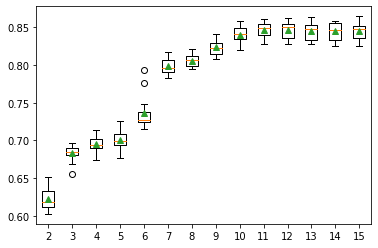

In [12]:
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train_1, y_train_1)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

It seems that there is a peak in 11-12 features and then performance falls slightly. This is to be expected, as RF is a Tree-based model, which are realtively immune to useless features. However, it is probably better to keep only the important ones, which in this case are 11 or 12.

Let's see which are the most and least important features according to RFE:

* **11 features:**

In [13]:
# Initialize and create pipeline
rfe_11ftrs = RFE(estimator=RandomForestClassifier(random_state=11), n_features_to_select=11)
over = RandomOverSampler(random_state=11)
scaler = StandardScaler()
model = RandomForestClassifier(random_state=11)
pipeline_11ftrs = imbpipeline(steps = [['over', over],
                                        ['scaler', scaler],
                                        ['rfe', rfe_11ftrs],      
                                        ['classifier', model]])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=11)
n_scores_11ftrs = cross_val_score(pipeline_11ftrs, X_train_1, y_train_1, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('ROC AUC with 11 features: %.3f (%.3f)' % (mean(n_scores_11ftrs), std(n_scores_11ftrs)))

ROC AUC with 11 features: 0.847 (0.010)


In [14]:
pipeline_11ftrs.fit(X_train_1, y_train_1)
df_rfe = pd.DataFrame(rfe_11ftrs.support_, index=X_train_1.columns, columns=['Rank'])
df_rfe

,Rank
CreditScore,True
Tenure,True
Balance,True
NumOfProducts,True
HasCrCard,False
IsActiveMember,True
EstimatedSalary,True
ratio_CreditScore_Age,True
ratio_EstimatedSalary_Age,True
Age_BoxCox,True


With 11 features the least important ones are 'Gender_Female', 'Geography_Spain', 'Geography_France' and 'HasCreditCard'.

* **12 features:**

In [15]:
# Initialize and create pipeline
rfe_12ftrs = RFE(estimator=RandomForestClassifier(random_state=11), n_features_to_select=12)
over = RandomOverSampler(random_state=11)
scaler = StandardScaler()
model = RandomForestClassifier(random_state=11)
pipeline_12ftrs = imbpipeline(steps = [['over', over],
                                        ['scaler', scaler],
                                        ['rfe', rfe_12ftrs],      
                                        ['classifier', model]])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=11)
n_scores_12ftrs = cross_val_score(pipeline_12ftrs, X_train_1, y_train_1, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('ROC AUC with 12 features: %.3f (%.3f)' % (mean(n_scores_12ftrs), std(n_scores_12ftrs)))

ROC AUC with 12 features: 0.847 (0.011)


In [16]:
pipeline_12ftrs.fit(X_train_1, y_train_1)
pd.DataFrame(rfe_12ftrs.support_, index=X_train_1.columns, columns=['Rank'])

,Rank
CreditScore,True
Tenure,True
Balance,True
NumOfProducts,True
HasCrCard,True
IsActiveMember,True
EstimatedSalary,True
ratio_CreditScore_Age,True
ratio_EstimatedSalary_Age,True
Age_BoxCox,True


With 12 features the least important ones are 'Gender_Female', 'Geography_Spain' and 'Geography_France'.

### RFE Conclusions

We can see that the results are consistent with the EDA and modeling from the 1st iteration notebook: Gender, Geography and HasCreditCard are the least important features. The only (relatively) important feature among these is 'Geography_Germany', which we saw in the EDA from the other notebook that had a much larger churning rate than the mean.

This should not be surprising. The last part from the previous notebook shows the feature importances of the RF Classifier, which is basically the RFE technique we are applying here.

I will use the model with 11 features as the final one for this technique.

**RFE Best Score: ROC-AUC=0,847**

This is slighlty better than the Base Model

## 2. PCA

I will use PCA as a dimensionality reduction technique and then train the obtained PCs with the base Random Forests Classifier.

I don't think this technique will have much impact, because PCA is benefitial in the following situations:
* When multi-colinearity exists between the features/variables.
* When the dimensions of the input features are high (e.g. a lot of variables).
* When there is noisy data.
Seeing the EDA done in my previous notebook of this dataset, there is not much multi-colinearity between features. Also, even with the 2 created features the dimension k=15 is small and much smaller than the number of training instances N=8000 (After train-test split). And finally, although there could be some noise, I don't think the dataset is particularly noisy.

Let's try and see how does PCA affect the final score.

In [17]:
X_train_2 = X_train
y_train_2 = y_train

In [18]:
# get a list of models to evaluate, from 2 to 15 PCs
def get_models():
    models = dict()
    for i in range(1,16):
        over = RandomOverSampler(random_state=11)
        scaler = StandardScaler()
        pca = PCA(n_components=i)
        model = RandomForestClassifier(random_state=11)
        steps = [['over', over], ['scaler', scaler], ['pca', pca], ['classifier', model]]
        models[str(i)] = imbpipeline(steps=steps)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=11)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>1 0.589 (0.017)
>2 0.675 (0.014)
>3 0.737 (0.017)
>4 0.733 (0.015)
>5 0.755 (0.016)
>6 0.767 (0.017)
>7 0.788 (0.013)
>8 0.802 (0.011)
>9 0.808 (0.011)
>10 0.815 (0.012)
>11 0.833 (0.011)
>12 0.834 (0.009)
>13 0.834 (0.011)
>14 0.835 (0.010)
>15 0.836 (0.010)


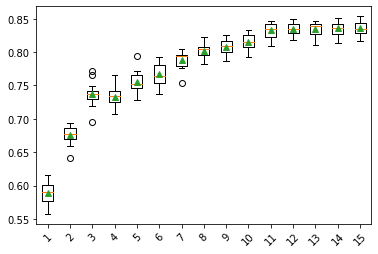

In [19]:
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train_2, y_train_2)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

There is not much improvement after 11 PCs so I'll keep that number. This way, we reduce the number of features from 15 to 11.

* **11 Principal Components:**

In [20]:
# Initialize and create pipeline
pca_11pc = PCA(n_components=11)
over = RandomOverSampler(random_state=11)
scaler = StandardScaler()
model = RandomForestClassifier(random_state=11)
pipeline_11pc = imbpipeline(steps = [['over', over],
                                        ['scaler', scaler],
                                        ['pca', pca_11pc],      
                                        ['classifier', model]])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=11)
n_scores_11pc = cross_val_score(pipeline_11pc, X_train_2, y_train_2, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('ROC AUC with 11 Principal Components: %.3f (%.3f)' % (mean(n_scores_11pc), std(n_scores_11pc)))

ROC AUC with 11 Principal Components: 0.833 (0.011)


We can see that PCA performs worse than both the base model and RFE. This is most likely due to the facts we previously mentioned about this dataset.

**PCA Best Score: ROC-AUC=0,833**

## 3. Lasso

I will use Lasso as a Feature Selection and then train the obtained non-zero features with the base Random Forests Classifier. 

* I will tune the alpha hyperparameter to see how does the score vary with the number of features in the model.

In [21]:
X_train_3 = X_train
y_train_3 = y_train

In [22]:
over = RandomOverSampler(random_state=11)
scaler = StandardScaler()
model = Lasso(random_state=11)

pipeline = imbpipeline(steps = [['over', over],
                                ['scaler', scaler],      
                                ['model', model]])

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.001,0.1,0.001)},
                      cv = 5, scoring="roc_auc",verbose=3
                      )

In [23]:
search.fit(X_train_3,y_train_3)
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
features = X_train.columns

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV] model__alpha=0.001 ..............................................
[CV] .................. model__alpha=0.001, score=0.758, total=   0.0s
[CV] model__alpha=0.001 ..............................................
[CV] .................. model__alpha=0.001, score=0.787, total=   0.1s
[CV] model__alpha=0.001 ..............................................
[CV] .................. model__alpha=0.001, score=0.768, total=   0.1s
[CV] model__alpha=0.001 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] .................. model__alpha=0.001, score=0.753, total=   0.1s
[CV] model__alpha=0.001 ..............................................
[CV] .................. model__alpha=0.001, score=0.790, total=   0.1s
[CV] model__alpha=0.002 ..............................................
[CV] .................. model__alpha=0.002, score=0.759, total=   0.0s
[CV] model__alpha=0.002 ..............................................
[CV] .................. model__alpha=0.002, score=0.788, total=   0.0s
[CV] model__alpha=0.002 ..............................................
[CV] .................. model__alpha=0.002, score=0.768, total=   0.1s
[CV] model__alpha=0.002 ..............................................
[CV] .................. model__alpha=0.002, score=0.753, total=   0.0s
[CV] model__alpha=0.002 ..............................................
[CV] .................. model__alpha=0.002, score=0.790, total=   0.0s
[CV] model__alpha=0.003 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:   23.7s finished


In [24]:
print('- Best alpha: ', search.best_params_)
print('- Best estimator ROC AUC: ', search.best_score_)
print('- Best estimator coefficients: ', np.abs(coefficients))
print('- Relevant features: ', np.array(features)[importance > 0])
print('- Irrelevant features: ', np.array(features)[importance == 0])

- Best alpha:  {'model__alpha': 0.013000000000000001}
- Best estimator ROC AUC:  0.7723446315248272
- Best estimator coefficients:  [0.         0.         0.03029151 0.00453961 0.         0.07395012
 0.         0.01670709 0.         0.1486469  0.         0.06386814
 0.         0.04315679 0.        ]
- Relevant features:  ['Balance' 'NumOfProducts' 'IsActiveMember' 'ratio_CreditScore_Age'
 'Age_BoxCox' 'Geography_Germany' 'Gender_Female']
- Irrelevant features:  ['CreditScore' 'Tenure' 'HasCrCard' 'EstimatedSalary'
 'ratio_EstimatedSalary_Age' 'Geography_France' 'Geography_Spain'
 'Gender_Male']


Although there are some relevant features that were also important in RFE (Age, NumOfProducts, etc), there are some differences: particularly, some Geography and Gender features that were pretty low in the importance scale of RFE but are relevant with the Lasso regression.

I will keep only the features with Importance >0 and train a RF model with those.

In [25]:
X_train_3 = X_train_3.drop(np.array(features)[importance == 0], axis=1)

X_train_3

,Balance,NumOfProducts,IsActiveMember,ratio_CreditScore_Age,Age_BoxCox,Geography_Germany,Gender_Female
6614,165312.27,1,0,20.264706,2.437258,0,0
2694,113146.98,2,1,21.655172,2.363809,1,0
7439,62339.81,2,0,16.000000,2.329951,0,1
3062,0.00,3,1,14.550000,2.509645,0,1
1902,0.00,1,1,23.424242,2.423673,0,1
...,...,...,...,...,...,...,...
390,147199.07,1,1,24.551724,2.363809,1,1
9014,121907.97,1,1,9.933333,2.679151,0,0
8031,0.00,2,0,18.500000,2.463018,0,1
9153,118214.32,3,0,14.083333,2.463018,1,0


In [26]:
# Initialize and create pipeline
over = RandomOverSampler(random_state=11)
scaler = StandardScaler()
model = RandomForestClassifier(random_state=11)
pipeline_lasso = imbpipeline(steps = [['over', over], ['scaler', scaler], ['classifier', model]])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=11)
n_scores_lasso = cross_val_score(pipeline_lasso, X_train_3, y_train_3, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('ROC AUC with Lasso for Feature Selection: %.3f (%.3f)' % (mean(n_scores_lasso), std(n_scores_lasso)))

ROC AUC with Lasso for Feature Selection: 0.831 (0.012)


We can see that Lasso is the worst performer here. This is most likely due to the fact that some of the features I dropped have some predictive power with the label. Maybe this relationship is not linear, and the Lasso being a linear model can't pick up on this.

**Lasso Best Score: ROC-AUC=0,831**

### Conclusions of the 3 techniques


According to the three techniques, the one with the **best performance was RFE with Random Forests**.
**RFE Best Score: ROC-AUC=0,847**

The same performance was obtained using 11 or 12 features. I will keep the one with 11 features because the model is less complex and might generalize better on the test set.

So, the best technique is the following:
- Standard Scaler
- Oversampling
- Random Forest with RFE
- 11 features

Now I am going to fine tune this model to get the best possible performance.

In [27]:
df_rfe[~df_rfe['Rank']].index.to_list()

['HasCrCard', 'Geography_France', 'Geography_Spain', 'Gender_Female']

In [28]:
rfe_11ftrs.support_

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True, False, False,  True])

# Fine-Tune the System

First of all, I am only going to keep the relevant features, which we obtained with RFE

In [29]:
# Columns to drop
cols_to_drop = df_rfe[~df_rfe['Rank']].index.to_list()
cols_to_drop

['HasCrCard', 'Geography_France', 'Geography_Spain', 'Gender_Female']

In [30]:
# Transform Training and Testing datasets
X_train = X_train.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)

In [31]:
# Initialize steps of the pipeline
oversampling = RandomOverSampler(random_state=11)
scaler = StandardScaler()
model = RandomForestClassifier(random_state=11)

# Pipeline
pipeline_tune = make_pipeline(oversampling, scaler, model)

# Parameter grid
grid_tune = {
    "randomforestclassifier__n_estimators": [10, 25, 50, 100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000],
    "randomforestclassifier__criterion": ["gini", "entropy"],
    "randomforestclassifier__max_depth": [10, 20, 30, 40, 50, 75, 100, 150, 200, None],
    "randomforestclassifier__min_samples_split": [1, 2, 3, 4, 5, 8, 10, 15, 20],
    "randomforestclassifier__min_samples_leaf": [1, 2, 3, 4, 5, 8, 10, 15, 20],
    "randomforestclassifier__max_features": ["auto", None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "randomforestclassifier__bootstrap": [True, False],
    "randomforestclassifier__max_samples": [None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
}

# Cross Validation
kf_tune = StratifiedKFold(n_splits=5)

# RandomizedSearchCV using RFC model, RandomOverSampler & StandardScaler. Scoring is ROC-AUC
rand_rf = RandomizedSearchCV(pipeline_tune, grid_tune, scoring='roc_auc', n_iter=10, n_jobs=-1, cv=kf_tune, random_state=11)

# Fit the model to the data
tuned_model = rand_rf.fit(X_train, y_train)

# Results
print(tuned_model.best_params_)
print('Best Score: %s' % tuned_model.best_score_)

{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__min_samples_leaf': 8, 'randomforestclassifier__max_samples': 0.1, 'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__bootstrap': False}
Best Score: 0.855273473240169


In [32]:
# Parameter grid
grid_tune_2 = {
    "randomforestclassifier__n_estimators": [70, 80, 90, 100, 110, 120, 130, 140, 150],
    "randomforestclassifier__criterion": ["entropy"],
    "randomforestclassifier__max_depth": [6, 7, 8, 9, 10, 11, 12, 13],
    "randomforestclassifier__min_samples_split": [6, 7, 8, 9, 10],
    "randomforestclassifier__min_samples_leaf": [6, 7, 8, 9, 10],
    "randomforestclassifier__max_features": [0.2, 0.25, 0.3, 0.35, 0.4],
    "randomforestclassifier__bootstrap": [False],
    "randomforestclassifier__max_samples": [None, 0.05, 0.1, 0,15, 0.2],
}

# Cross Validation
kf_tune = StratifiedKFold(n_splits=5)

# RandomizedSearchCV using RFC model, RandomOverSampler & StandardScaler. Scoring is ROC-AUC
rand_rf_2 = RandomizedSearchCV(pipeline_tune, grid_tune_2, scoring='roc_auc', n_iter=10, n_jobs=-1, cv=kf_tune, random_state=11)

# Fit the model to the data
tuned_model_2 = rand_rf_2.fit(X_train, y_train)

# Results
print(tuned_model_2.best_params_)
print('Best Score: %s' % tuned_model_2.best_score_)

{'randomforestclassifier__n_estimators': 140, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_samples': 0.2, 'randomforestclassifier__max_features': 0.4, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__bootstrap': False}
Best Score: 0.8565332126243608


* **Final Training ROC-AUC: 0.858**

## Results: Test dataset Scores

Finally, I will use my final model on the Test dataset (which hasn't been used at all yet, and shouldn't be used for training) and see the scores I get.

In [33]:
labels = ['No Churn', 'Churn']
y_pred = tuned_model_2.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    No Churn       0.93      0.84      0.88      1593
       Churn       0.54      0.74      0.63       407

    accuracy                           0.82      2000
   macro avg       0.73      0.79      0.75      2000
weighted avg       0.85      0.82      0.83      2000



<AxesSubplot:>

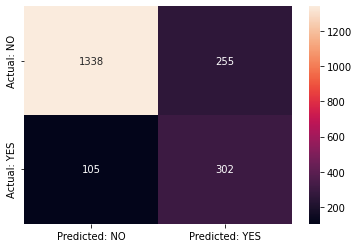

In [34]:
#Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix
xlabels = ['Predicted: NO', 'Predicted: YES']
ylabels = ['Actual: NO', 'Actual: YES']
sns.heatmap(data=cm, xticklabels=xlabels, yticklabels=ylabels, annot=True, fmt='g')

In [35]:
roc_auc_score(y_test, y_pred)

0.7909697062239436

* **Final Test ROC-AUC: 0.791**

In [36]:
accuracy_score(y_test, y_pred)

0.82

In [37]:
importance = tuned_model_2.best_estimator_[2].feature_importances_

In [38]:
def plot_feature_importance(importance, names, model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

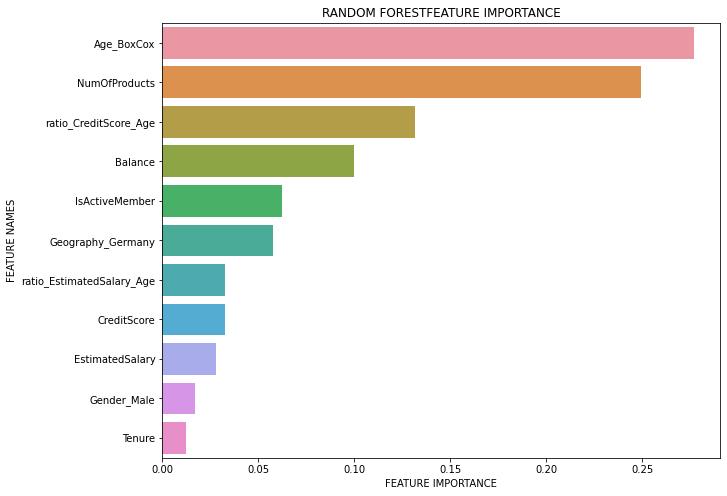

In [39]:
plot_feature_importance(importance, X_train.columns, 'RANDOM FOREST')

# Final Results and conclusions

Here is a table with the results of every method we've tested:

In [40]:
# initialize list of lists
results = [['Base Random Forest model', 'Train', mean(n_scores_base)], 
           ['1. RFE + Random Forest', 'Train', mean(n_scores_11ftrs)], 
           ['2. PCA + Random Forest', 'Train', mean(n_scores_11pc)],
           ['3. Lasso + Random Forest', 'Train', mean(n_scores_lasso)],
           ['1. RFE + Random Forest, Tuned', 'Train', tuned_model_2.best_score_],
           ['Base Random Forest model, Tuned', 'Test', roc_auc_score(y_test, y_pred)],
           ['1. RFE + Random Forest, Tuned', 'Test', 0.78996]]
 
# Create the pandas DataFrame
df_results = pd.DataFrame(results, columns = ['Method', 'Set', 'ROC-AUC'])

df_results

,Method,Set,ROC-AUC
0,Base Random Forest model,Train,0.844611
1,1. RFE + Random Forest,Train,0.846632
2,2. PCA + Random Forest,Train,0.832578
3,3. Lasso + Random Forest,Train,0.830978
4,"1. RFE + Random Forest, Tuned",Train,0.856533
5,"Base Random Forest model, Tuned",Test,0.790970
6,"1. RFE + Random Forest, Tuned",Test,0.789960


**The final score of the model is Test ROC-AUC: 0.791**. This was done with 11 features that were selected via RFE.

The improvement over the model without RFE (which was done in the previous notebook) is negligible (only in the 3rd decimal). The training score of both methods (with and without RFE) were around 0.85, so the model is clearly overfitting. 

However, it is important to note that with RFE we reached the same performance but using 11 features instead of 15 (27% reduction). This might not be such an important thing here as there are only 10000 samples. But a simpler model would be easier to scale and consumes less time and computing power.

As a next step, I would try to constrain the model further to solve the overfitting issue. In the Randomized Searched, I could try using less samples or features per tree, aswell as reducing the depth of the trees. This strategy might get worse results in the training set (higher bias) but better results in the test set (less variance).